# "Big Pandas" - Dask from the Inside
## Part 1 - Set up
### PyData Amsterdam tutorial, 7 April 2017
### Stephen Simmons


Download pre-prepared data from here:  
* http://www.stevesimmons.com/pydata-ams2017/flights-201601-201701-csv-xz.tar (151MB)
* http://www.stevesimmons.com/pydata-ams2017/flights-201601-201701-parq.tar (158MB)


These imports are needed to run the full set of examples

In [1]:
# Complete set of Python 3.6 imports used for these examples

# Standard modules
import io
import logging
import lzma
import multiprocessing
import os
import ssl
import sys
import time
import urllib.request
import zipfile

# Third-party modules
import fastparquet      # Needs python-snappy and llvmlite
import graphviz         # To visualize Dask graphs 
import numpy as np
import pandas as pd
import psutil           # Memory stats
import dask
import dask.dataframe as dd
import bokeh.io         # For Dask profile graphs
import seaborn as sns   # For colormaps

# Support multiple lines of output in each cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Don't wrap tables
pd.options.display.max_rows = 20
pd.options.display.max_columns = 20
pd.options.display.width = 300

# Show matplotlib and bokeh graphs inline in Jupyter notebook
%matplotlib inline
bokeh.io.output_notebook()

print(sys.version)
np.__version__, pd.__version__, dask.__version__

Loading BokehJS ...

3.6.0 |Continuum Analytics, Inc.| (default, Dec 23 2016, 12:22:00) 
[GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]


('1.11.3', '0.19.2', '0.14.1')

In [143]:
task = ddf.head(n=2, npartitions=2, compute=False)

ValueError: only 1 partitions, head received 2

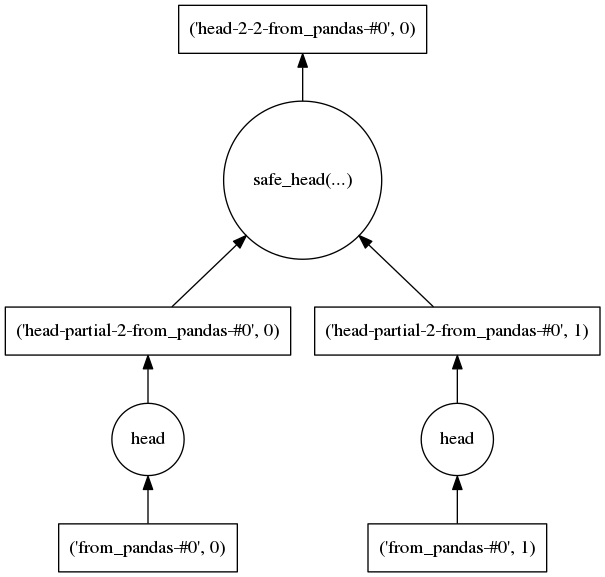

In [91]:
task.visualize()

In [92]:
task.dask

{('from_pandas-de36e0f9b56aa90e818c2dda9e03260c', 0):    a  b  c
 0  1  2  3
 1  4  5  6
 2  7  8  9, ('from_pandas-de36e0f9b56aa90e818c2dda9e03260c', 1):     a   b   c
 3  10  11  12
 4  13  14  15, ('head-2-2-from_pandas-de36e0f9b56aa90e818c2dda9e03260c',
  0): (<function dask.dataframe.core.safe_head>, (<function dask.dataframe.core._concat>,
   [('head-partial-2-from_pandas-de36e0f9b56aa90e818c2dda9e03260c', 0),
    ('head-partial-2-from_pandas-de36e0f9b56aa90e818c2dda9e03260c',
     1)]), 2), ('head-partial-2-from_pandas-de36e0f9b56aa90e818c2dda9e03260c',
  0): (<methodcaller: head>,
  ('from_pandas-de36e0f9b56aa90e818c2dda9e03260c', 0),
  2), ('head-partial-2-from_pandas-de36e0f9b56aa90e818c2dda9e03260c',
  1): (<methodcaller: head>, ('from_pandas-de36e0f9b56aa90e818c2dda9e03260c',
   1), 2)}

In [142]:
task._keys()

[('head-1-2-from_pandas-de36e0f9b56aa90e818c2dda9e03260c', 0)]

In [65]:
print(pd.DataFrame.__doc__)

 Two-dimensional size-mutable, potentially heterogeneous tabular data
    structure with labeled axes (rows and columns). Arithmetic operations
    align on both row and column labels. Can be thought of as a dict-like
    container for Series objects. The primary pandas data structure

    Parameters
    ----------
    data : numpy ndarray (structured or homogeneous), dict, or DataFrame
        Dict can contain Series, arrays, constants, or list-like objects
    index : Index or array-like
        Index to use for resulting frame. Will default to np.arange(n) if
        no indexing information part of input data and no index provided
    columns : Index or array-like
        Column labels to use for resulting frame. Will default to
        np.arange(n) if no column labels are provided
    dtype : dtype, default None
        Data type to force, otherwise infer
    copy : boolean, default False
        Copy data from inputs. Only affects DataFrame / 2d ndarray input

    Examples
    ---

In [66]:
print(dd.DataFrame.__doc__)


    Implements out-of-core DataFrame as a sequence of pandas DataFrames

    Parameters
    ----------

    dask: dict
        The dask graph to compute this DataFrame
    name: str
        The key prefix that specifies which keys in the dask comprise this
        particular DataFrame
    meta: pandas.DataFrame
        An empty ``pandas.DataFrame`` with names, dtypes, and index matching
        the expected output.
    divisions: tuple of index values
        Values along which we partition our blocks on the index
    


In [ ]:
dd.from_pandas()

In [52]:
ddf = dd.from_pandas(df, chunksize=2)
task = ddf[ddf.a>2]

In [53]:
task.compute()

,a,b,c
1,4,5,6
2,7,8,9
3,10,11,12


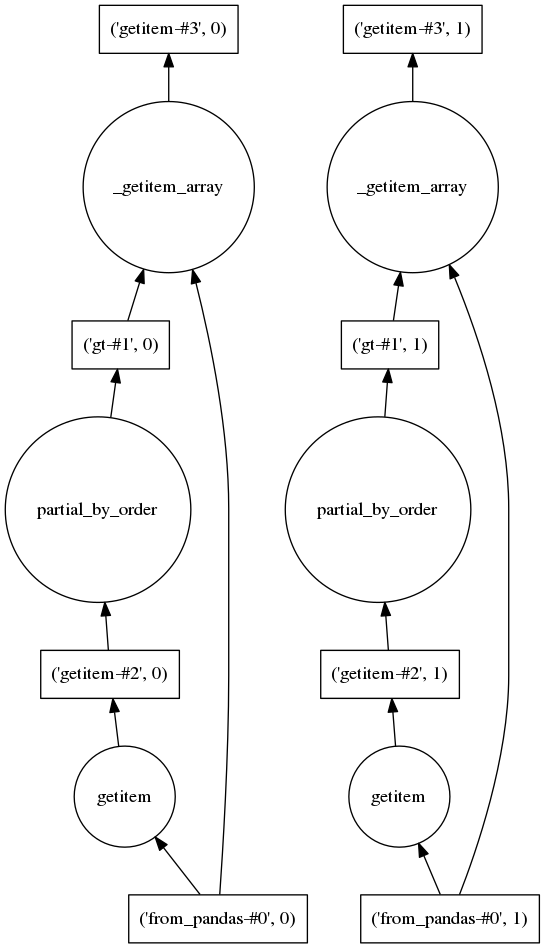

In [54]:
task.visualize()

In [55]:
print(dd.DataFrame.__doc__)


    Implements out-of-core DataFrame as a sequence of pandas DataFrames

    Parameters
    ----------

    dask: dict
        The dask graph to compute this DataFrame
    name: str
        The key prefix that specifies which keys in the dask comprise this
        particular DataFrame
    meta: pandas.DataFrame
        An empty ``pandas.DataFrame`` with names, dtypes, and index matching
        the expected output.
    divisions: tuple of index values
        Values along which we partition our blocks on the index
    


In [56]:
task._meta

,a,b,c


In [57]:
task.npartitions
task.divisions

2

(0, 2, 3)

In [58]:
task._name

'getitem-845adeb1f3f6fe7d5b8f1f046ae677ca'

In [59]:
task.dask

{('from_pandas-37d6c4e12ebefd78272a6470f70a4b21', 0):    a  b  c
 0  1  2  3
 1  4  5  6, ('from_pandas-37d6c4e12ebefd78272a6470f70a4b21', 1):     a   b   c
 2   7   8   9
 3  10  11  12, ('getitem-845adeb1f3f6fe7d5b8f1f046ae677ca',
  0): (<methodcaller: _getitem_array>, ('from_pandas-37d6c4e12ebefd78272a6470f70a4b21',
   0), ('gt-82445471718415f2cbdf08d57f178b4f',
   0)), ('getitem-845adeb1f3f6fe7d5b8f1f046ae677ca',
  1): (<methodcaller: _getitem_array>,
  ('from_pandas-37d6c4e12ebefd78272a6470f70a4b21', 1),
  ('gt-82445471718415f2cbdf08d57f178b4f',
   1)), ('getitem-ed2b560b212841d2cd96769f0eecacf2',
  0): (<function _operator.getitem>,
  ('from_pandas-37d6c4e12ebefd78272a6470f70a4b21', 0),
  'a'), ('getitem-ed2b560b212841d2cd96769f0eecacf2',
  1): (<function _operator.getitem>, ('from_pandas-37d6c4e12ebefd78272a6470f70a4b21',
   1), 'a'), ('gt-82445471718415f2cbdf08d57f178b4f',
  0): (<function dask.compatibility.apply>, <function dask.array.core.partial_by_order>, [('getitem-ed2b56

In [60]:
task.dask[(task._name,0)]

(<methodcaller: _getitem_array>,
 ('from_pandas-37d6c4e12ebefd78272a6470f70a4b21', 0),
 ('gt-82445471718415f2cbdf08d57f178b4f', 0))

In [61]:
task.dask[(task._name,1)]

(<methodcaller: _getitem_array>,
 ('from_pandas-37d6c4e12ebefd78272a6470f70a4b21', 1),
 ('gt-82445471718415f2cbdf08d57f178b4f', 1))

In [62]:
task.compute??

In [48]:
task2.compute()

a     8
b    10
c    12
dtype: int64

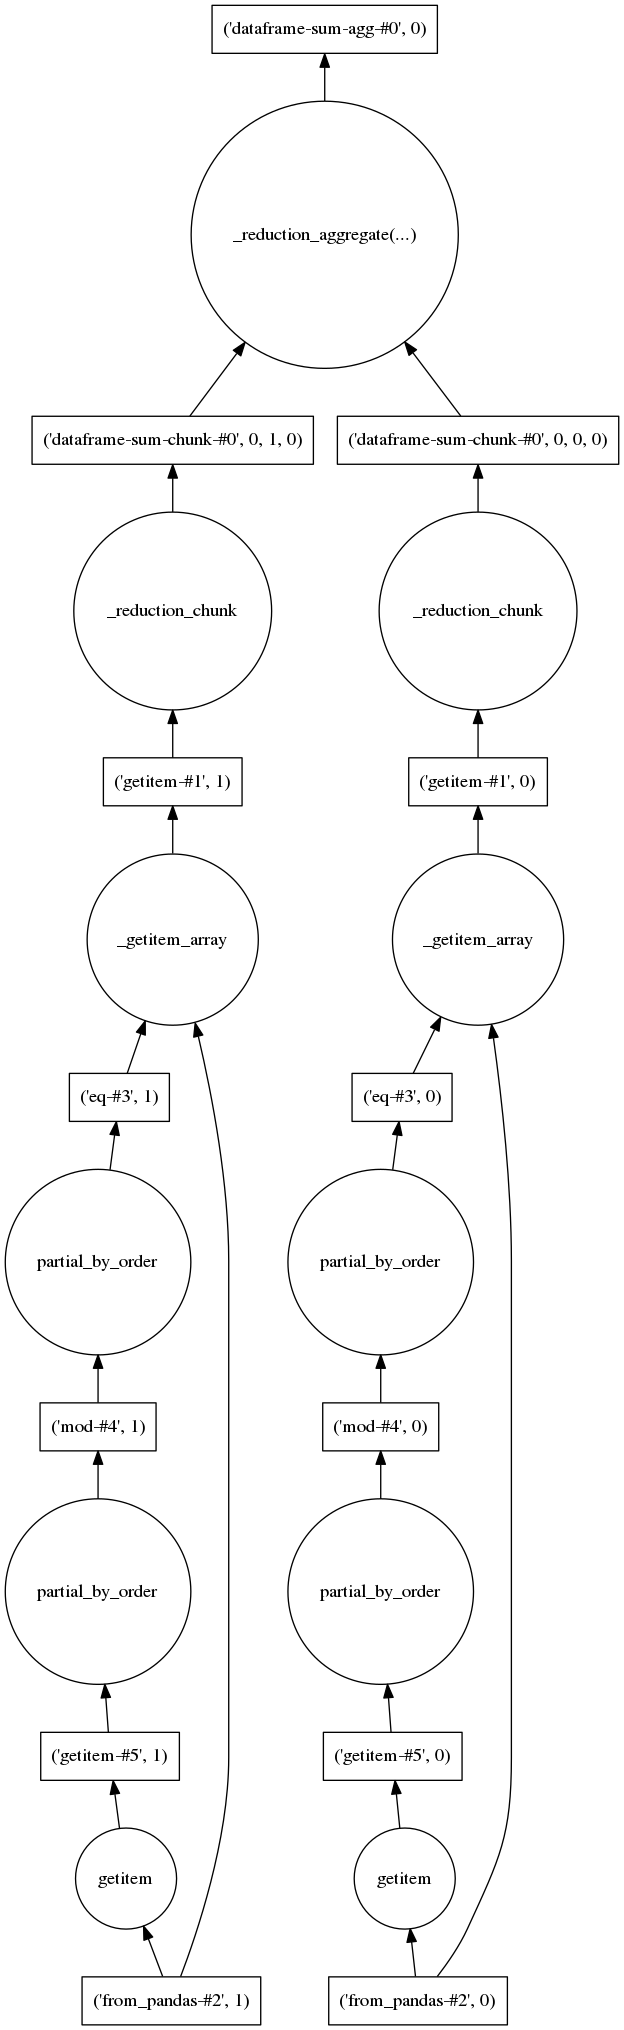

In [49]:
task2.visualize()

In [51]:
task2.dask[(task2._name,0)]

(<function dask.compatibility.apply>,
 <function dask.dataframe.core._reduction_aggregate>,
 [(<function dask.dataframe.core._concat>,
   [('dataframe-sum-chunk-4f1ac59b65a08dd36a001a1db6a540cf', 0, 0, 0),
    ('dataframe-sum-chunk-4f1ac59b65a08dd36a001a1db6a540cf', 0, 1, 0)])],
 {'aca_aggregate': <methodcaller: sum>, 'axis': 0, 'skipna': True})